In [1]:
import os
import cv2
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from ultralytics import YOLO
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/Users/uditanshusatpathy/miniconda3/envs/yolov8_new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/uditanshusatpathy/Downloads/Neophyte/neoDIShA-Fashion/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/uditanshusatpathy/Downloads/Neophyte/neoDIShA-Fashion/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return re

## Helper Functions

In [2]:
def infer(model,image_path):
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:-1]
    predictions = model.predict(image_path,save=False,show=False,show_labels=False,conf=0.5)
    for prediction in predictions:
        masks = prediction.masks.xy
        new_list = []
        for items in masks[0]:
            new_list.append(items[0]/img_width)
            new_list.append(items[1]/img_height)
        return new_list
    
def normalize_points(contour_points, image_width, image_height):
    # Normalize the points
    print(type(contour_points))
    normalized_points = contour_points.astype(float) / np.array([image_width, image_height])
    return normalized_points

def convert_contour_to_yolov8(contour_points, class_index):
    # Flatten the contour points to a 1D array
    flattened_points = contour_points.reshape(-1, 2)

    # Create YOLOv8 label string
    label_string = f"{class_index}"
    for point in flattened_points:
        label_string += f" {point[0]} {point[1]}"

    return label_string

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def calculate_side_centre(point1, point2):
    """
    Calculate the center point between two given points.
    """
    x = (point1[0] + point2[0]) / 2
    y = (point1[1] + point2[1]) / 2
    return (x, y)

def calculate_point_on_line(point1, point2, distance_ratio):
    """
    Calculate a point on the line between two given points based on a distance ratio.
    """
    x = point1[0] + distance_ratio * (point2[0] - point1[0])
    y = point1[1] + distance_ratio * (point2[1] - point1[1])
    return (x, y)

def find_quadrilateral_center_and_points(box_set1, distance_ratio=0.4):
    """
    Find the center point of the quadrilateral and points 20% away from it
    on the lines between side_centre1, side_centre3 and side_centre2, side_centre4.
    """
    
    p1, p2, p3, p4 = box_set1
    side_centre1 = calculate_side_centre(p1, p2)
    side_centre2 = calculate_side_centre(p2, p3)
    side_centre3 = calculate_side_centre(p3, p4)
    side_centre4 = calculate_side_centre(p4, p1)

    print("side_centre1:", side_centre1)

    quadrilateral_center = calculate_side_centre(side_centre1, side_centre3)

    

    point_on_line1 = calculate_point_on_line(side_centre1, side_centre3, distance_ratio=0.4)
    point_on_line2 = calculate_point_on_line(side_centre2, side_centre4, distance_ratio=0.4)
    point_on_line3 = calculate_point_on_line(side_centre1, side_centre3, distance_ratio=0.6)
    point_on_line4 = calculate_point_on_line(side_centre2, side_centre4, distance_ratio=0.6)
    
    return quadrilateral_center, point_on_line1, point_on_line2, point_on_line3, point_on_line4

In [50]:
def calculate_iou(contour1, contour2):
    def polygon_area(polygon):
        n = len(polygon)
        area = 0.0
        for i in range(n):
            j = (i + 1) % n
            area += polygon[i][0] * polygon[j][1]
            area -= polygon[j][0] * polygon[i][1]
        area = abs(area) / 2.0
        return area

    def intersection_area(polygon1, polygon2):
        def line_intersection(line1, line2):
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div == 0:
                return None  # Lines don't intersect

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            return x, y

        intersection_points = []
        for i in range(len(polygon1)):
            for j in range(len(polygon2)):
                line1 = [polygon1[i], polygon1[(i + 1) % len(polygon1)]]
                line2 = [polygon2[j], polygon2[(j + 1) % len(polygon2)]]
                intersection = line_intersection(line1, line2)
                if intersection:
                    intersection_points.append(intersection)

        return polygon_area(intersection_points)
    area_contour1 = polygon_area(contour1)
    area_contour2 = polygon_area(contour2)
    intersection = intersection_area(contour1, contour2)
    iou = ((area_contour1 + area_contour2) - intersection) / intersection
    return abs(iou)

In [4]:
image_dir = "/Users/uditanshusatpathy/Downloads/Neophyte/neoMetry/crop_images/1703332928.907184"
# image_files = glob.glob(image_dir +".jpg")
image_file = image_dir +".jpg"
save_folder= './save_txt/'
sam_checkpoint = "/Users/uditanshusatpathy/Downloads/Neophyte/neoMetry/neometry/mobile_sam.pt"
model_path = "best.pt"
model_type = "vit_t"
load_strt_time = time.time()
model = YOLO(model_path)
mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(mobile_sam)
load_end_time = time.time()
print(load_end_time-load_strt_time)

0.3197939395904541


In [5]:
image = cv2.imread(image_file)
img_height, img_width = image.shape[:-1]
img_name = os.path.basename(image_file)
label_name = os.path.splitext(os.path.basename(image_file))[0] + ".txt"
process_strt_time = time.time()
seg_list = infer(model,image_file)
# print(seg_list)

points_set1 = np.array(seg_list).reshape(-1, 2)

scaled_points_set1 = (points_set1 * np.array([img_width, img_height])).astype(int)

rect_set1 = cv2.minAreaRect(scaled_points_set1)
box_set1 = cv2.boxPoints(rect_set1).astype(int)


image 1/1 /Users/uditanshusatpathy/Downloads/Neophyte/neoMetry/crop_images/1703332928.907184.jpg: 544x640 1 object, 545.8ms
Speed: 3.5ms preprocess, 545.8ms inference, 9.5ms postprocess per image at shape (1, 3, 544, 640)


In [6]:
for i in box_set1:
    cv2.circle(image,(i[0],i[1]), 3, (0,255,0), -1)


center_point, point_on_line1, point_on_line2, point_on_line3, point_on_line4 = find_quadrilateral_center_and_points(box_set1)

side_centre1: (185.5, 331.5)


In [8]:
predictor.set_image(image)
points_list=[center_point, point_on_line1, point_on_line2, point_on_line3, point_on_line4]
label_list=[1,1,1,1,1]
label_string_list= []
input_point = np.array(points_list)
input_label = np.array(label_list)
masks, scores, logits = predictor.predict(
point_coords=input_point,
point_labels=input_label,
multimask_output=False,
            )

In [9]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [10]:
contour, _ = cv2.findContours(masks[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour

(array([[[402, 450]],
 
        [[404, 450]]], dtype=int32),
 array([[[409, 449]],
 
        [[408, 450]],
 
        [[407, 450]],
 
        [[407, 452]],
 
        [[408, 453]],
 
        [[408, 454]],
 
        [[409, 454]],
 
        [[409, 451]],
 
        [[410, 450]]], dtype=int32),
 array([[[381, 447]],
 
        [[380, 448]],
 
        [[380, 451]],
 
        [[381, 452]],
 
        [[384, 452]],
 
        [[385, 451]],
 
        [[385, 448]],
 
        [[384, 447]]], dtype=int32),
 array([[[397, 444]],
 
        [[397, 445]],
 
        [[395, 447]],
 
        [[392, 447]],
 
        [[391, 448]],
 
        [[391, 452]],
 
        [[393, 452]],
 
        [[394, 453]],
 
        [[393, 454]],
 
        [[383, 454]],
 
        [[382, 455]],
 
        [[381, 455]],
 
        [[381, 456]],
 
        [[390, 456]],
 
        [[391, 457]],
 
        [[392, 457]],
 
        [[393, 458]],
 
        [[398, 458]],
 
        [[399, 457]],
 
        [[400, 457]],
 
        [[401, 456]],
 
 

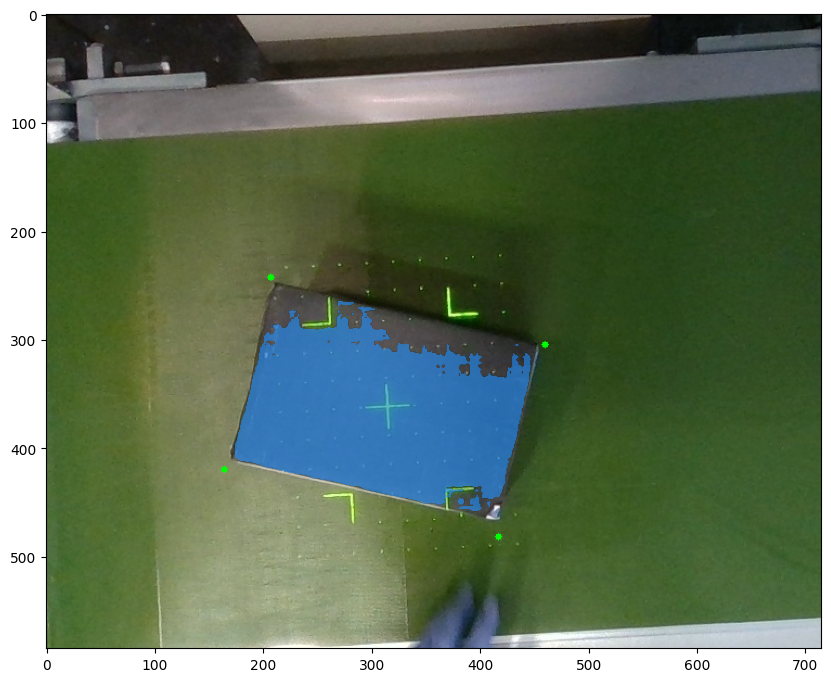

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())

In [61]:
area_list = []
count_countour = 0
while count_countour < len(contour):
    area = cv2.contourArea(contour[count_countour])
    area_list.append(area) 
    count_countour += 1


area_index = area_list.index(max(area_list))
normalized_points = normalize_points(contour[area_index], img_width, img_height)
normalized_points

<class 'numpy.ndarray'>


array([[[    0.40699,     0.46154]],

       [[    0.40559,     0.46325]],

       [[     0.4028,     0.46325]],

       ...,

       [[    0.41818,     0.46325]],

       [[    0.40979,     0.46325]],

       [[    0.40839,     0.46154]]])

In [52]:
def convert_normalized_to_image_coordinates(normalized_points, image):
    height, width, _ = image.shape
    return np.squeeze((normalized_points * [width, height])).astype(int)

image_points_sam = convert_normalized_to_image_coordinates(normalized_points, image)

In [54]:
image_points_sam

array([[291, 270],
       [290, 271],
       [288, 271],
       ...,
       [299, 271],
       [293, 271],
       [292, 270]])

In [21]:
seg_list

[0.2953125,
 0.43125,
 0.2890625,
 0.4388888888888889,
 0.2890625,
 0.4407986111111111,
 0.2875,
 0.4427083333333333,
 0.2875,
 0.4579861111111111,
 0.2828125,
 0.46371527777777777,
 0.2828125,
 0.465625,
 0.28125,
 0.4675347222222222,
 0.28125,
 0.4904513888888889,
 0.2796875,
 0.49236111111111114,
 0.2796875,
 0.4942708333333333,
 0.2765625,
 0.49809027777777776,
 0.2765625,
 0.5,
 0.275,
 0.5019097222222222,
 0.275,
 0.5210069444444444,
 0.2734375,
 0.5229166666666667,
 0.2734375,
 0.5267361111111111,
 0.2703125,
 0.5305555555555556,
 0.2703125,
 0.5324652777777777,
 0.26875,
 0.534375,
 0.26875,
 0.5649305555555556,
 0.2640625,
 0.5706597222222223,
 0.2640625,
 0.5725694444444445,
 0.2625,
 0.5744791666666667,
 0.2625,
 0.5954861111111112,
 0.2578125,
 0.6012152777777777,
 0.2578125,
 0.603125,
 0.25625,
 0.6050347222222222,
 0.25625,
 0.6203125,
 0.2546875,
 0.6222222222222222,
 0.2546875,
 0.6241319444444444,
 0.2515625,
 0.6279513888888889,
 0.2515625,
 0.6298611111111111,
 0.25

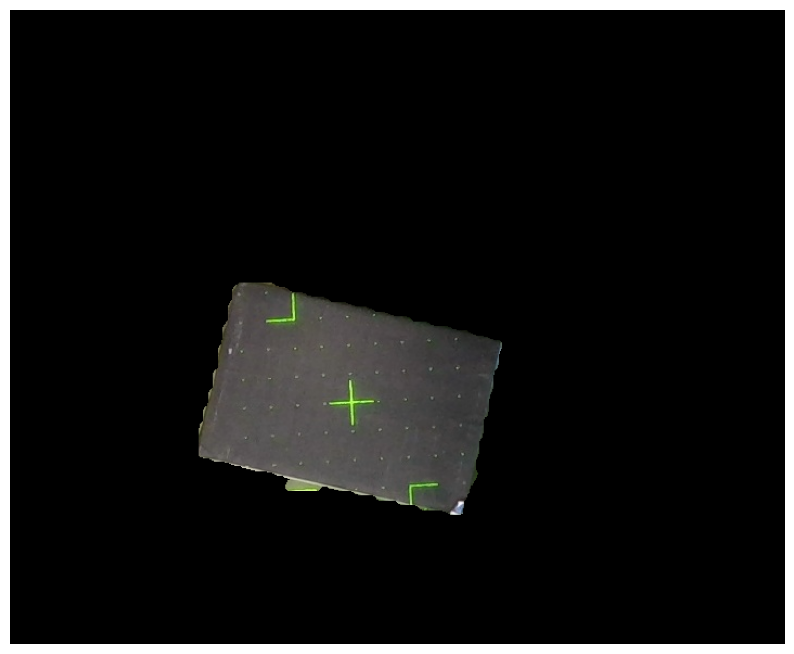

In [30]:
height, width, _ = image.shape
image_points = np.array([(int(x * width), int(y * height)) for x, y in zip(seg_list[::2], seg_list[1::2])], dtype=np.int32)

# Create a blank mask
mask = np.zeros_like(image)

# Draw filled contour on the mask
cv2.fillPoly(mask, [image_points], color=(255, 255, 255))  # Fill with white color

# Add the filled contour to the original image using bitwise_and
result = cv2.bitwise_and(image, mask)

# Plot the filled contour on the image
plt.figure(figsize=(10, 10))
plt.imshow(result)  # Convert BGR to RGB for Matplotlib
plt.axis('off')  # Hide axis
plt.show()

In [29]:
image_points_sam

array([[291, 270],
       [290, 271],
       [288, 271],
       ...,
       [299, 271],
       [293, 271],
       [292, 270]])

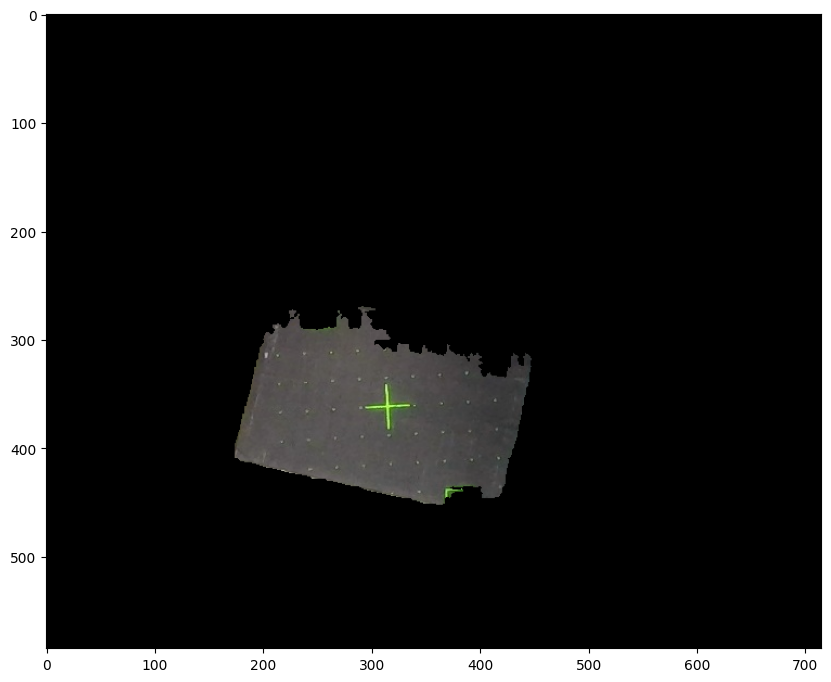

In [53]:



mask = np.zeros_like(image)

cv2.fillPoly(mask, [image_points_sam], (255, 255, 255))  # Fill with white color for demonstration

result = cv2.bitwise_and(image, mask)

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

In [51]:
iou = calculate_iou(image_points_sam, image_points)
print((iou))

0.7551506982289543


In [56]:
height, width, _ = image.shape
if iou<0.8:
    result_mask = normalize_points(image_points, width, height)
else:
    result_mask = normalize_points(image_points_sam, width, height)

<class 'numpy.ndarray'>


In [59]:
result_mask

array([[     0.2951,     0.43077],
       [    0.28811,     0.43761],
       [    0.28811,     0.43932],
       [    0.28671,     0.44103],
       [    0.28671,     0.45641],
       [    0.28252,     0.46325],
       [    0.28252,     0.46496],
       [    0.28112,     0.46667],
       [    0.28112,     0.48889],
       [    0.27832,     0.49231],
       [    0.27832,     0.49402],
       [    0.27552,     0.49744],
       [    0.27552,     0.49915],
       [    0.27413,     0.50085],
       [    0.27413,     0.51966],
       [    0.27273,     0.52137],
       [    0.27273,      0.5265],
       [    0.26993,     0.52991],
       [    0.26993,     0.53162],
       [    0.26853,     0.53333],
       [    0.26853,      0.5641],
       [    0.26294,     0.56923],
       [    0.26294,     0.57094],
       [    0.26154,     0.57436],
       [    0.26154,     0.59487],
       [    0.25734,         0.6],
       [    0.25734,     0.60171],
       [    0.25594,     0.60342],
       [    0.25594,

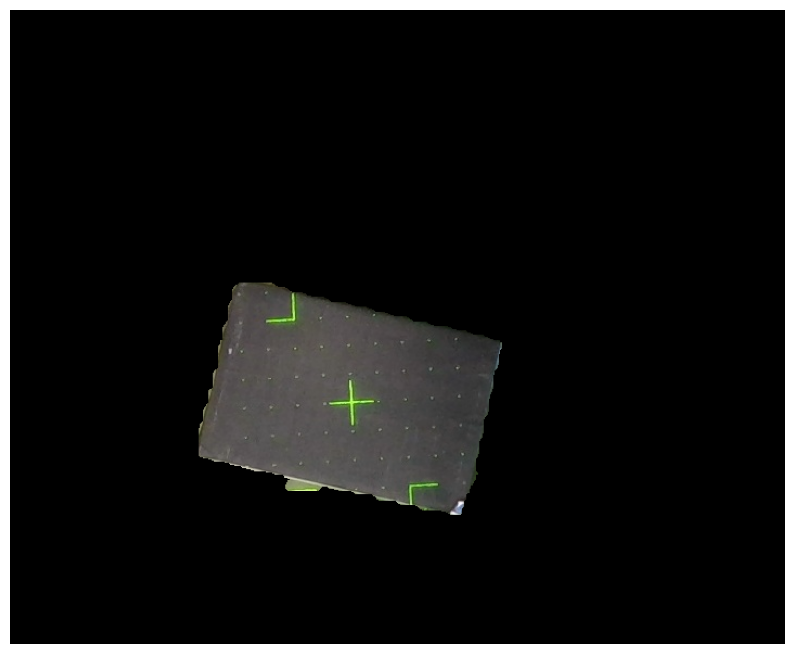

In [60]:
res_mask = convert_normalized_to_image_coordinates(result_mask, image)
mask = np.zeros_like(image)

# Draw filled contour on the mask
cv2.fillPoly(mask, [res_mask], color=(255, 255, 255))  # Fill with white color

# Add the filled contour to the original image using bitwise_and
result = cv2.bitwise_and(image, mask)

# Plot the filled contour on the image
plt.figure(figsize=(10, 10))
plt.imshow(result)  # Convert BGR to RGB for Matplotlib
plt.axis('off')  # Hide axis
plt.show()